In [1]:
import tables
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'large',
'axes.labelsize': 'large',
'axes.titlesize':'x-large',
'date.converter': 'concise'}
pylab.rcParams.update(params)
mpl.rcParams["figure.dpi"]= 300

In [2]:
properties=tables.open_file('trail_properties.h5')
print(properties)

trail_properties.h5 (File) ''
Last modif.: '2023-03-22T11:41:52+00:00'
Object Tree: 
/ (RootGroup) ''
/N_track (CArray(5451,)zlib(9)) ''
/avg_brightness (CArray(5451,)zlib(9)) ''
/duration (CArray(5451,)zlib(9)) ''
/max_brightness (CArray(5451,)zlib(9)) ''
/nrun (CArray(5451,)zlib(9)) ''
/start (CArray(5451,)zlib(9)) ''
/t0 (CArray(5451,)zlib(9)) ''
/time_in_night (CArray(5451,)zlib(9)) ''
/unique_pix (CArray(5451,)zlib(9)) ''
/velocity (CArray(5451,)zlib(9)) ''
/zenith (CArray(5451,)zlib(9)) ''



In [3]:
import sys
import paramiko
import pandas as pd
import json
import sshtunnel
import mariadb
import sys
import paramiko
import datetime
from datetime import timedelta
import numpy as np
import math
import re

def getMdbCursor():
    conn = mariadb.connect(
        user="spencers",
        password="GieLope9ohquaep3xi",
        host='127.0.0.1',
        port=12345,
        database="HD_tables"
    )

    # Instantiate Cursor
    cur = conn.cursor()
    return cur

def load_collection(CMD):
    cur = getMdbCursor()
    print(CMD)
    cur.execute(CMD)
    df = pd.DataFrame(cur.fetchall())
    column_title = re.search('SELECT(.*)FROM', CMD)
    df.columns = list(column_title.group(1).replace(" ", "").split(","))
    return df

def getCollForStat(col):
    allCols = getMdbCursor()
    allCols.execute('SHOW COLUMNS FROM '+ 'HD_test'+'.'+col)
    cols = allCols.fetchall()

    list_allCols = []
    for i in  range(len(cols)):
        list_allCols = list_allCols + [cols[i][0]]
    list_allCols_str =  ','.join(list_allCols[1:])
    cur = getMdbCursor()
    CMD = "SELECT " + list_allCols_str +" FROM HD_test."+col+" WHERE Run > 100 ORDER BY HD_test."+col+".WhenEntered asc"
    cur.execute(CMD)
    df = pd.DataFrame(cur.fetchall())
    df_atm =  df
    df_atm.columns = list_allCols[1:]
    #df_atm = df_atm.drop_duplicates(['Run','Telescope'],keep='last')

    df_atm =df_atm.merge(df_run, on=['Run'])

    df_atm['Year'] = [e.year  for e in list(df_atm['TimeOfStart'])]
    df_atm['Month'] = [e.month  for e in list(df_atm['TimeOfStart'])]
    df_atm['doy'] = [e.timetuple().tm_yday for e in list(df_atm['TimeOfStart'])]
    df_atm['Nrun']=1
    df_atm.groupby(['Month']).sum()
    return df_atm


CMD = "SELECT Run, Duration, Run_Start_Time FROM  HD_test.Monitor_Run_Data"
df_run = load_collection(CMD)
df_run.columns = ['Run', 'Run_Duration', 'Run_Start_Time']
df_run = df_run.drop_duplicates(['Run'],keep='last')
df_run['Run_Start_Time'] = pd.to_datetime(df_run['Run_Start_Time'])
df_run2 = df_run.copy(deep=True)


SELECT Run, Duration, Run_Start_Time FROM  HD_test.Monitor_Run_Data


In [4]:
tracks=properties.root['N_track'].read()+1
nrun=properties.root['nrun'].read()
t0=properties.root['t0'].read()
avg_brightness=properties.root['avg_brightness'].read()
duration=properties.root['duration'].read()
max_brightness=properties.root['max_brightness'].read()
trailstart=properties.root['start'].read()
unique_pix=properties.root['unique_pix'].read()
velocity=properties.root['velocity'].read()
zenith=properties.root['zenith'].read()
df_tracks=pd.DataFrame({'Run':nrun,'Tracks':tracks,'t0':t0,'avg_brightness':avg_brightness,'duration':duration,'max_brightness':max_brightness,'trailstart':trailstart,'unique_pix':unique_pix,'velocity':velocity,'zenith':zenith})
print(df_tracks)

         Run  Tracks            t0  avg_brightness  duration  max_brightness  \
0     155172     0.0  1.572302e+09            -1.0      -1.0            -1.0   
1     155173     0.0  1.572304e+09            -1.0      -1.0            -1.0   
2     155174     0.0  1.572306e+09            -1.0      -1.0            -1.0   
3     155179     0.0  1.572314e+09            -1.0      -1.0            -1.0   
4     155246     0.0  1.572391e+09            -1.0      -1.0            -1.0   
...      ...     ...           ...             ...       ...             ...   
5446  180348     4.0  1.675219e+09          1887.7       4.8          4371.2   
5447  180348     5.0  1.675219e+09          1189.9       4.7          1616.3   
5448  180349     1.0  1.675221e+09          1835.8       4.5          4006.5   
5449  180349     2.0  1.675221e+09          1103.4       4.7          1438.9   
5450  180379     1.0  1.675301e+09          1144.3       5.3          1794.6   

        trailstart  unique_pix  velocit

In [5]:
df_run=df_run[df_run['Run'].isin(df_tracks['Run'])]
print(df_run)

           Run  Run_Duration      Run_Start_Time
368226  155179        1081.0 2019-10-29 02:00:57
368227  155172        1682.0 2019-10-28 22:34:18
368229  155173        1682.0 2019-10-28 23:03:52
368230  155174        1681.0 2019-10-28 23:33:20
368259  155246        1681.0 2019-10-29 23:21:51
...        ...           ...                 ...
405616  180021        1682.0 2022-12-28 23:27:20
405633  180043        1683.0 2022-12-29 23:37:24
405643  180045        1682.0 2022-12-30 00:37:40
405646  180044        1682.0 2022-12-30 00:08:23
405647  180046        1682.0 2022-12-30 01:06:51

[4715 rows x 3 columns]


In [6]:
df_tracks=df_tracks.merge(df_run2,left_on='Run',right_on='Run')
df_tracks=df_tracks[df_tracks['Tracks']!=0]


In [7]:
totdur = df_run.groupby(pd.Grouper(key="Run_Start_Time", freq="M")).sum()
tottracks = df_tracks.groupby(pd.Grouper(key="Run_Start_Time", freq="M")).sum()
ratio = tottracks['duration']/totdur['Run_Duration']
print(ratio)

Run_Start_Time
2019-10-31    0.000428
2019-11-30    0.002158
2019-12-31    0.000368
2020-01-31    0.001160
2020-02-29    0.008623
2020-03-31    0.002330
2020-04-30    0.002136
2020-05-31    0.002555
2020-06-30    0.001820
2020-07-31    0.002188
2020-08-31    0.000918
2020-09-30    0.001752
2020-10-31    0.002839
2020-11-30    0.001991
2020-12-31    0.002086
2021-01-31    0.005005
2021-02-28    0.002437
2021-03-31    0.003427
2021-04-30    0.001783
2021-05-31    0.002902
2021-06-30    0.002353
2021-07-31    0.001863
2021-08-31    0.002500
2021-09-30    0.002516
2021-10-31    0.002872
2021-11-30    0.002976
2021-12-31    0.004205
2022-01-31    0.003954
2022-02-28    0.002120
2022-03-31    0.002170
2022-04-30    0.002549
2022-05-31    0.001903
2022-06-30    0.002003
2022-07-31    0.001873
2022-08-31    0.002259
2022-09-30    0.001028
2022-10-31    0.003610
2022-11-30    0.005841
2022-12-31    0.001999
2023-01-31    0.003157
2023-02-28    0.007192
Freq: M, dtype: float64


<Axes: xlabel='Run_Start_Time'>

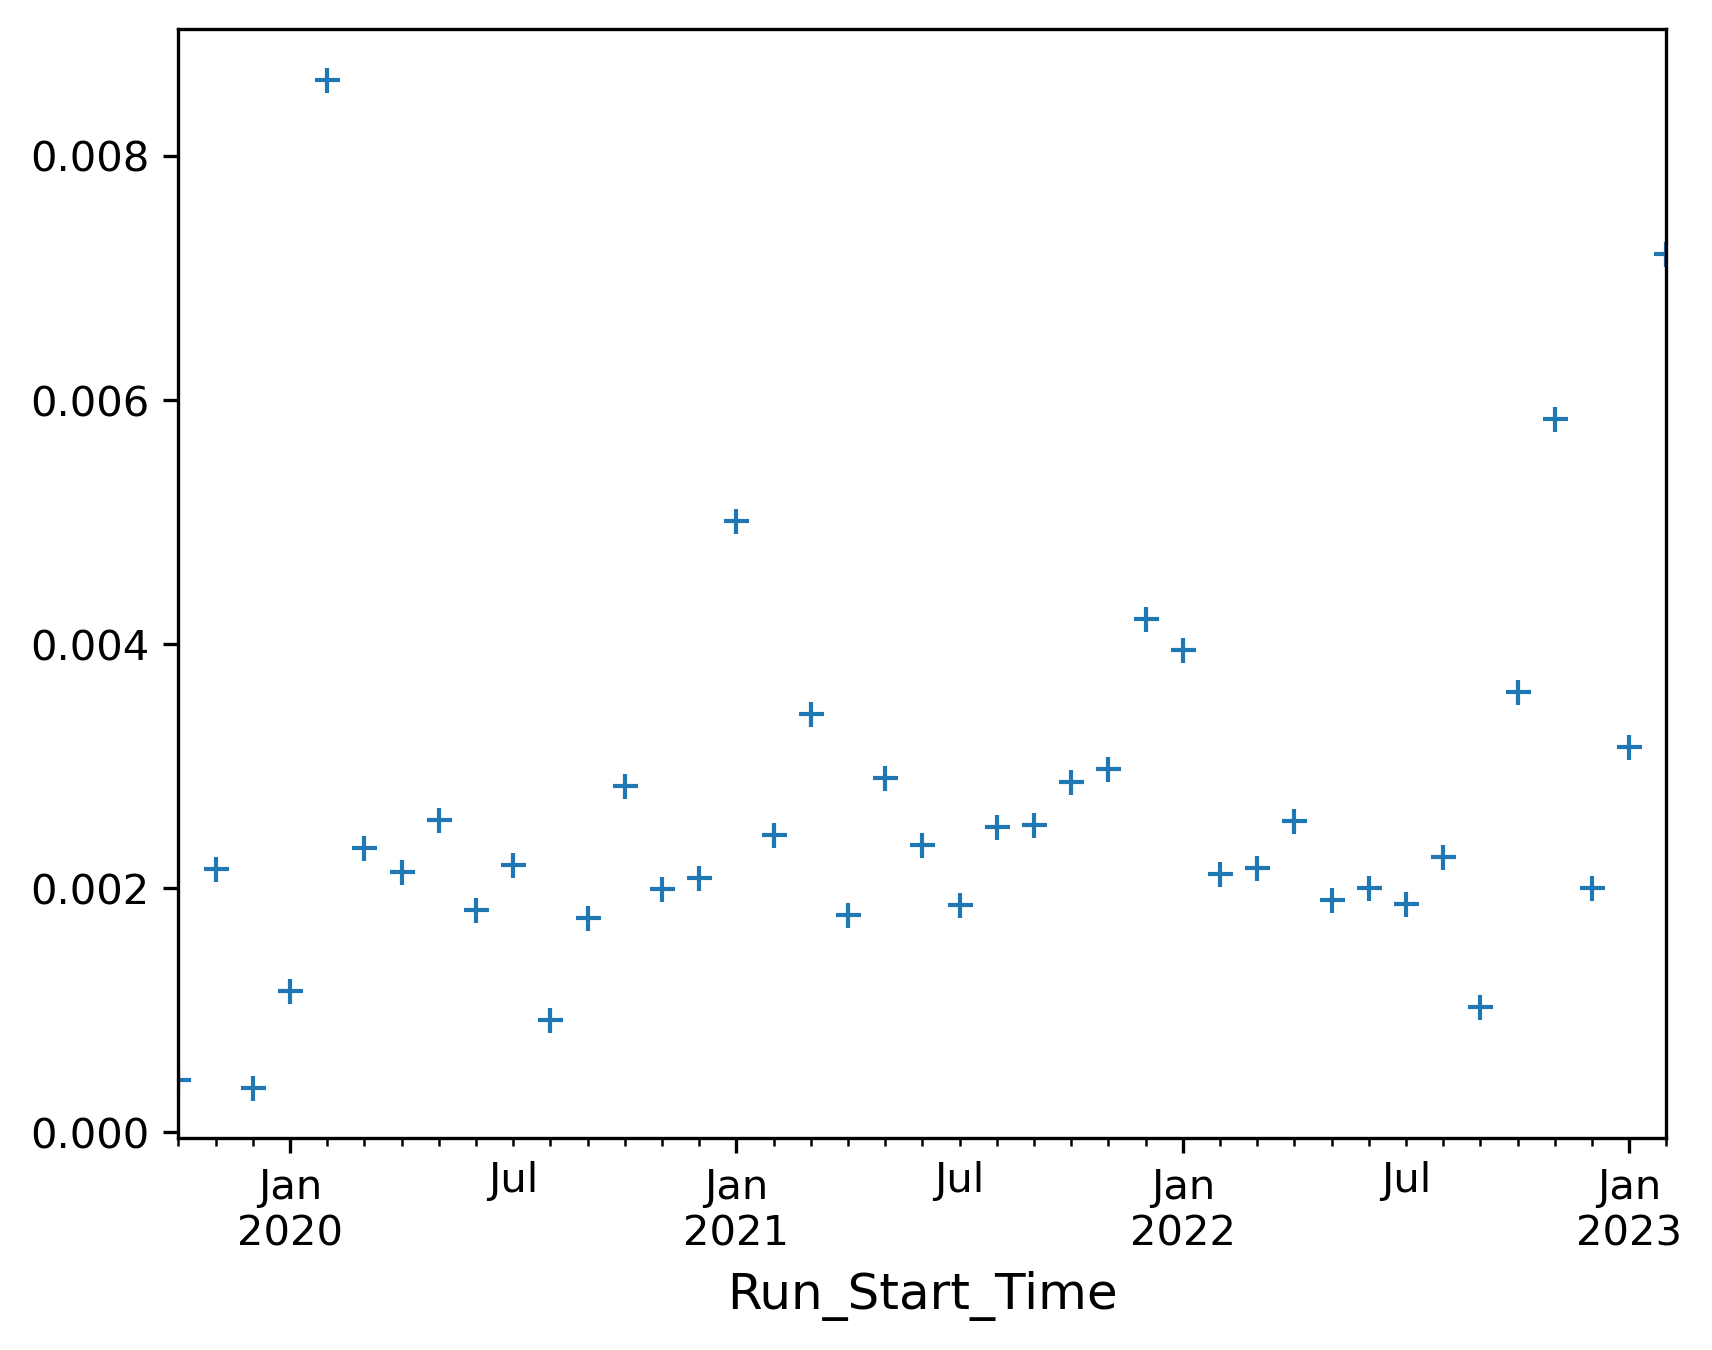

In [8]:
ratio.plot(linestyle='None',marker='+')

(41,) (41,)
(40,)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'> <class 'numpy.ndarray'>
(40,)
[datetime.datetime(2019, 10, 31, 0, 0)
 datetime.datetime(2019, 11, 30, 0, 0)
 datetime.datetime(2019, 12, 31, 0, 0)
 datetime.datetime(2020, 1, 31, 0, 0) datetime.datetime(2020, 3, 31, 0, 0)
 datetime.datetime(2020, 4, 30, 0, 0) datetime.datetime(2020, 5, 31, 0, 0)
 datetime.datetime(2020, 6, 30, 0, 0) datetime.datetime(2020, 7, 31, 0, 0)
 datetime.datetime(2020, 8, 31, 0, 0) datetime.datetime(2020, 9, 30, 0, 0)
 datetime.datetime(2020, 10, 31, 0, 0)
 datetime.datetime(2020, 11, 30, 0, 0)
 datetime.datetime(2020, 12, 31, 0, 0)
 datetime.datetime(2021, 1, 31, 0, 0) datetime.datetime(2021, 2, 28, 0, 0)
 datetime.datetime(2021, 3, 31, 0, 0) datetime.datetime(2021, 4, 30, 0, 0)
 datetime.datetime(2021, 5, 31, 0, 0) datetime.datetime(2021, 6, 30, 0, 0)
 datetime.datetime(2021, 7, 31, 0, 0) datetime.datetime(2021, 8, 31, 0, 0)
 datetime.datetime(2021, 9, 30, 0, 0)
 datetime.datetime(2021, 1

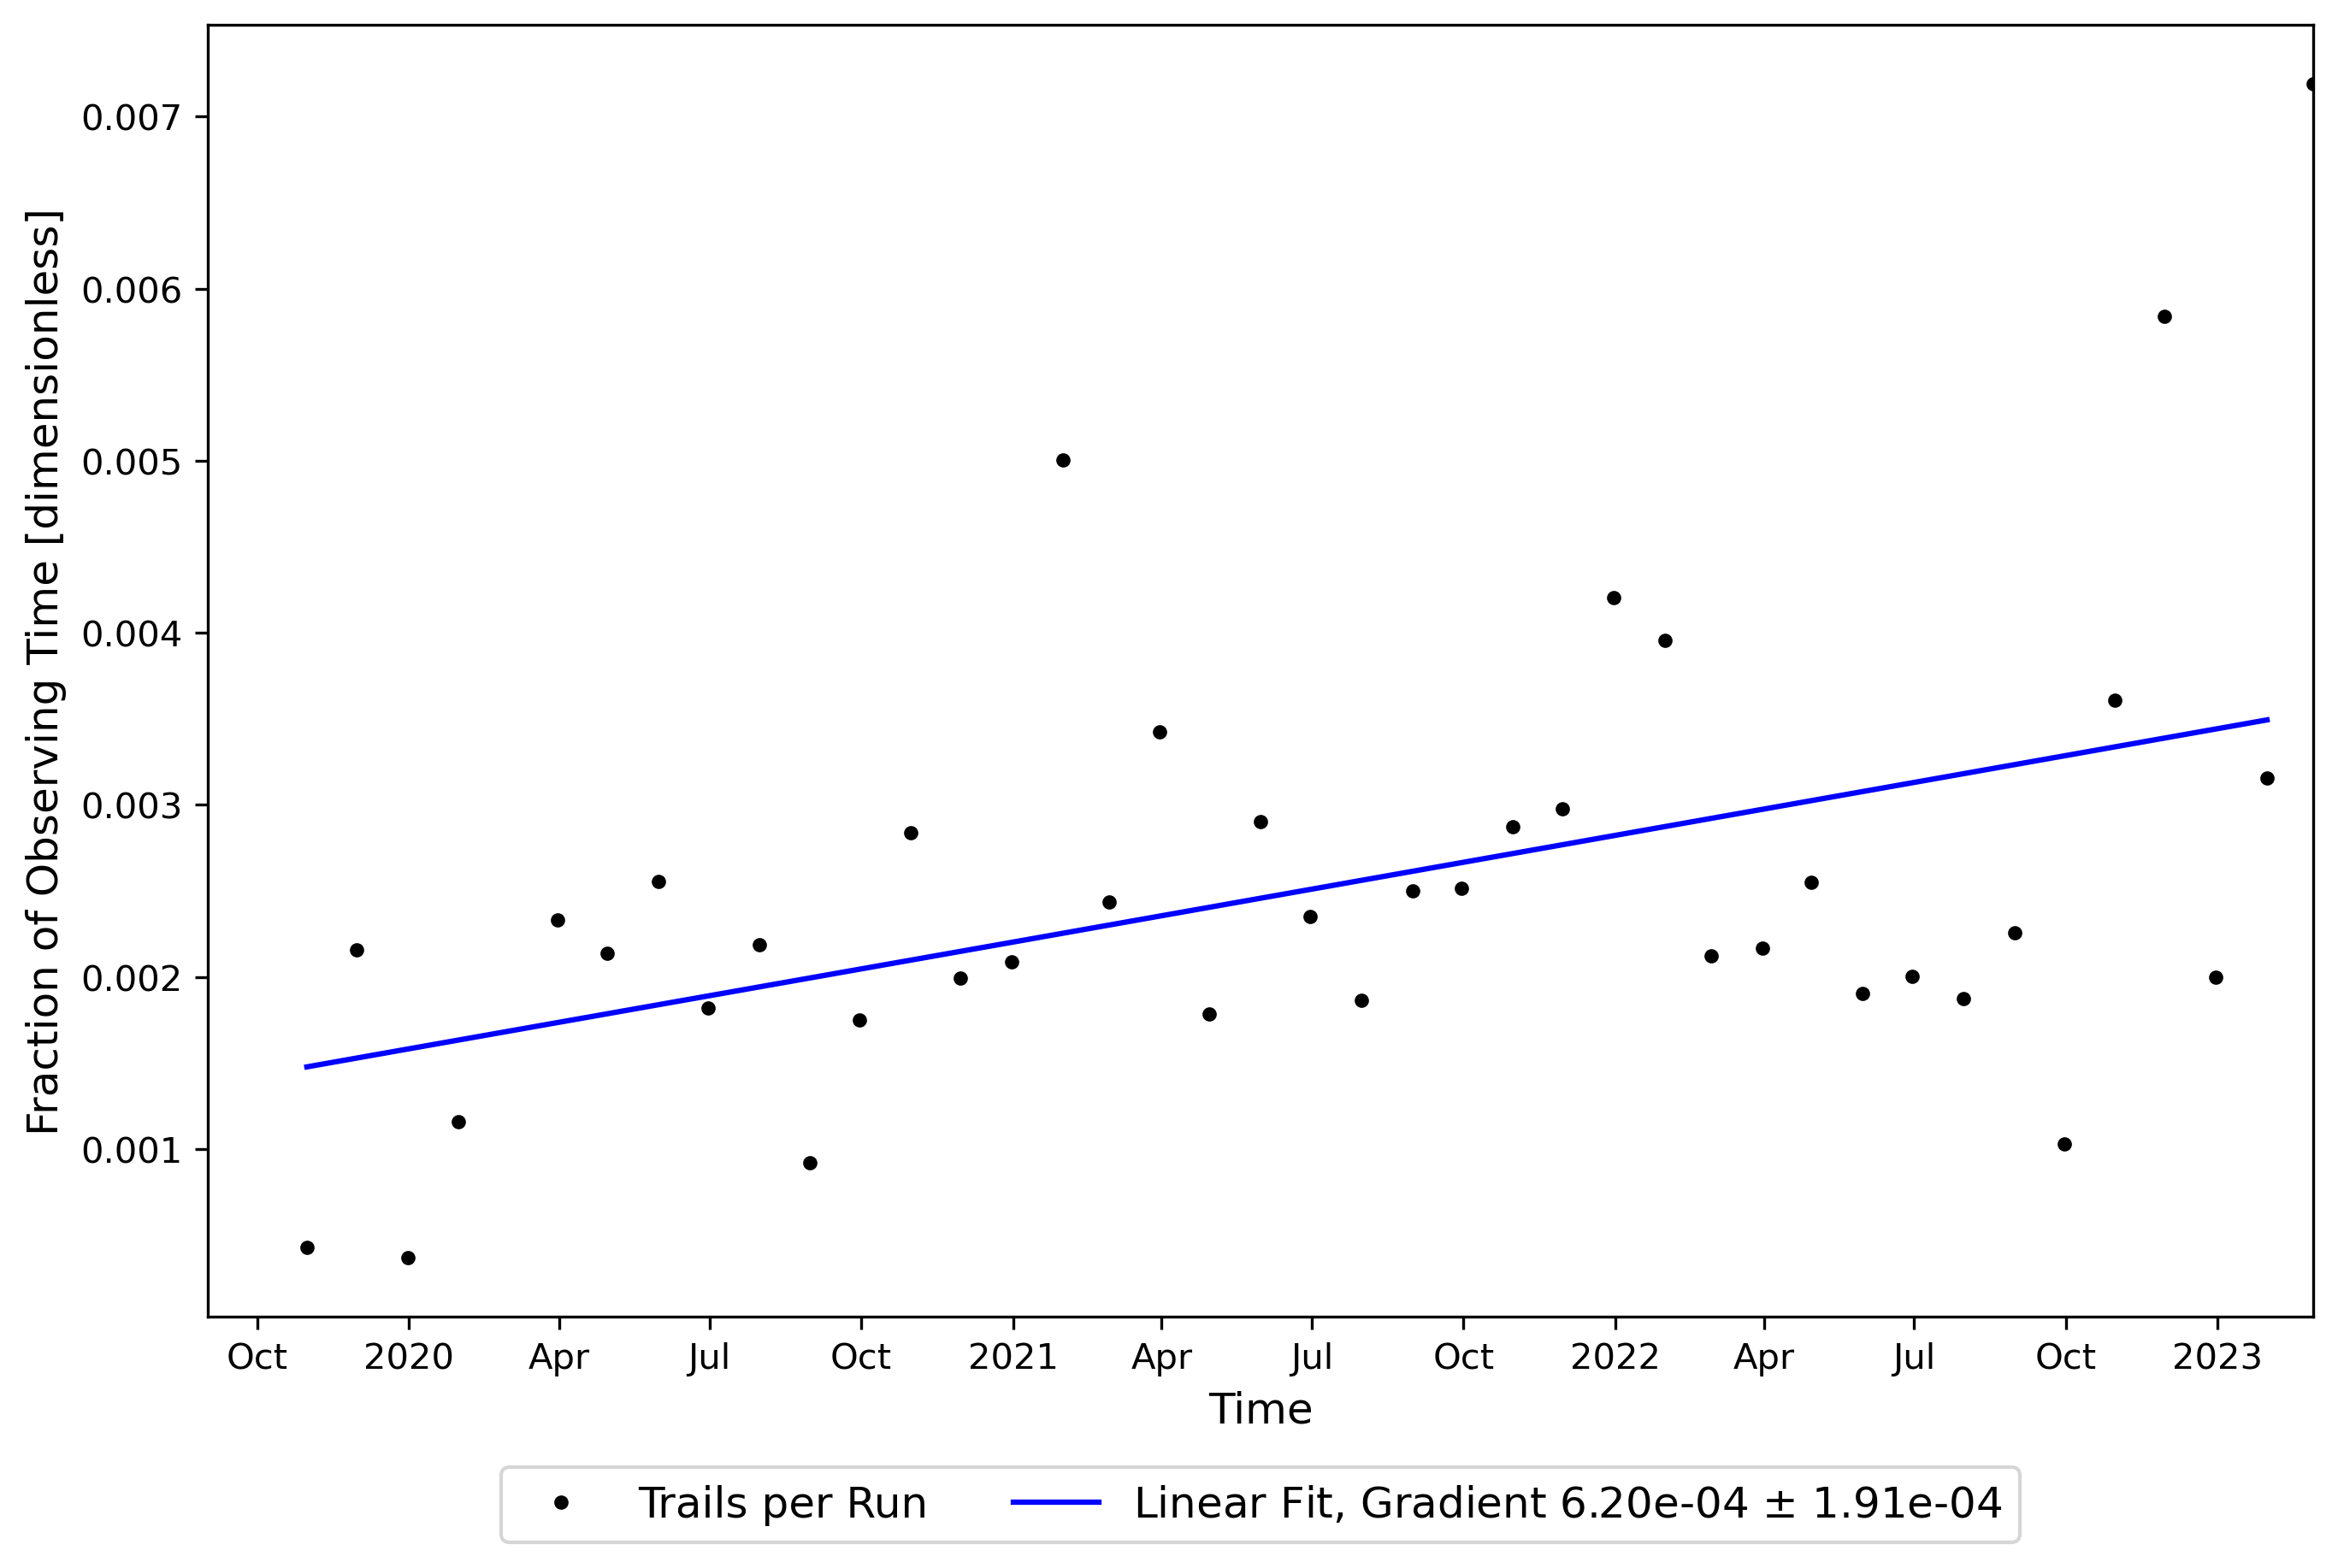

In [9]:
import matplotlib.dates as mdates
from datetime import datetime
import scipy
from astropy.time import Time

def lin(x,m,t):
    return m*x+t

figure_size = (9,6)

fig1, ax1 = plt.subplots(1, 1, figsize=figure_size, constrained_layout=True)
#plt.rcParams['date.converter'] = 'concise'
plt.rcParams['date.converter'] = 'concise'
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=12, maxticks=20))

err = np.sqrt(ratio)
x=ratio.index
y=ratio.to_numpy()
print(x.shape,y.shape)
x=np.delete(x,4)
print(x.shape)
print(type(x),type(y))
y=np.delete(y,4)
print(y.shape)
x2=x.copy()

x=x.to_pydatetime()

print(x)
print(dir(x))
x = Time(x,format='datetime')
x.format = "decimalyear"

popt,pcov = scipy.optimize.curve_fit(lin,x.value,y)

ax1.plot(x2[:-1], lin(x.value, popt[0], popt[1])[:-1], c = "blue", 
           label = "Linear Fit, Gradient {:.2e}".format(popt[0])+" $\pm$ {:.2e}".format(np.sqrt(np.diag(pcov))[0]) )

ax1.errorbar(x2,y, fmt=".k", label = "Trails per Run")

ax1.set_xlabel("Time")
ax1.set_ylabel("Fraction of Observing Time [dimensionless]")
ax1.set_xlim([datetime(2019, 9,1), datetime(2023, 2, 28)])
handles, labels = plt.gca().get_legend_handles_labels()

order=[1,0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper center', bbox_to_anchor=(0.5, -0.1),
             fancybox=True,ncols=2)
plt.savefig('obsfraction.png')
print(np.mean(ratio),np.std(ratio))